##Extract data

In [ ]:
from IPython.display import clear_output

!cp /content/drive/MyDrive/laba-dataset.zip /content/dataset.zip
!unzip /content/dataset.zip

clear_output()

##Install dependancy for graph plotting

In [2]:
!pip install livelossplot --quiet

##Imports

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from livelossplot import PlotLosses

##Hyperparameters

In [5]:
TEST_SPLIT = 0.2
ROOT = "/content/samples/"
NUM_SPLITS = 8 #Amount of splits we do along width (should be more than amount of letters in captcha)

##Dataset implementation

In [6]:
class CaptchaDataset(Dataset):

    def __init__(self, root, label2idx, train=True, transforms=None):
        self.images = glob.glob(os.path.join(root, "*.png"))
        end = int(len(self.images) * (1 - TEST_SPLIT))
        if train:
            self.images = self.images[:end]
        else:
            self.images = self.images[end:]
        self.transforms = transforms

    def __len__(self,):
        return len(self.images)

    def change_transform(self, transform):
        self.transforms = transform
      
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transforms is not None:
            image = self.transforms(image)
        transcript = image_path.rsplit("/", 1)[-1].replace(".png", "")
        labels = torch.Tensor([label2idx[char] for char in transcript])

        return {"images": image, "labels": labels, "text": transcript}

##Creation of dictionary of possible tokens, "-" for blank for CTC Loss

In [8]:
labels = glob.glob(os.path.join(ROOT, "*.png"))

def create_dict(labels):
    tokens = ["-"]
    dict_ = {"-": 0}
    counter = 1
    for label in labels:
        transcript = label.rsplit("/", 1)[-1].replace(".png", "")
        for char in transcript:
            if not char in dict_:
                dict_[char] = counter
                counter += 1
                tokens.append(char)
    tokens.append("|")
    return dict_, counter, tokens

label2idx, dict_len, tokens = create_dict(labels)

## Train/test transforms and creation of Dataloaders

In [9]:
train_transforms = transforms.Compose([transforms.Resize((128, 256)),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = transforms.Compose([transforms.Resize((128, 256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                      

train_dataset = CaptchaDataset(ROOT, label2idx, True, train_transforms)
test_dataset = CaptchaDataset(ROOT, label2idx, False, test_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


##Model architecture

In [10]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels, downsample=True):
        super().__init__()

        if downsample:
            stride = 2
        else:
            stride = 1

        self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels))
        
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.downsample = None

        self.relu = nn.ReLU()
        self.out_channels = out_channels
            
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ConvExtractor(nn.Module):

    def __init__(self, in_channels, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList([ResBlock(in_channels, 32)])
        num_channels = 32
        for i in range(num_blocks - 1):
            self.blocks.append(ResBlock(num_channels, num_channels))
            num_channels = num_channels
        
        
    def forward(self, x):
        out = x
        for block in self.blocks:
            out = block(out)
        return out


class BiLSTM(nn.Module):

    def __init__(self, input_dim, num_layers, num_hidden, num_labels):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, num_hidden, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(num_hidden * 2, num_labels)

    def forward(self, x):
        out, _ = self.lstm(x)
        return F.log_softmax(self.fc(out), dim=-1)


class OCRModel(nn.Module):

    def __init__(self, extract_model, num_splits, num_hidden, num_layers, num_labels, device):
        super().__init__()

        self.extract_model = extract_model
        self.num_splits = num_splits
        self.feature_size = ((256 // (2 ** self.extract_model.num_blocks)) // num_splits) * (128 // (2 ** self.extract_model.num_blocks)) * 32 
        self.lstm_model = BiLSTM(self.feature_size, num_layers, num_hidden, num_labels)
    
    def forward(self, x):
        bs = x.shape[0]
        features = self.extract_model(x)
        w = features.shape[-1]
        sequence = torch.split(features, w // self.num_splits, -1)
        sequence = torch.stack([elem.reshape(bs, self.feature_size) for elem in sequence], 1)
        out = self.lstm_model(sequence)
        return out


##Utils (such as CER, Greedy CTC Decoder)

In [11]:
def levenshteinDistance(str1, str2):
    m = len(str1)
    n = len(str2)
    d = [[i] for i in range(1, m + 1)]   
    d.insert(0, list(range(0, n + 1)))
    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if str1[i - 1] == str2[j - 1]:
                substitutionCost = 0
            else:
                substitutionCost = 1
            d[i].insert(j, min(d[i - 1][j] + 1,
                               d[i][j - 1] + 1,
                               d[i - 1][j - 1] + substitutionCost))
    return d[-1][-1]

def calc_cer(str1, str2):
    return levenshteinDistance(str1, str2) / len(str1)
        
class GreedyCTCDecoder(nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission):
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        joined = "".join([self.labels[i] for i in indices])
        return joined.replace("|", " ").strip().split()


greedy_decoder = GreedyCTCDecoder(tokens)

##Model Init

In [14]:
model = ConvExtractor(3, 4).cuda();
ocr_model = OCRModel(model, NUM_SPLITS, 256, 2, dict_len, "cuda")
ocr_model.cuda();

##Training Loop and Loss/CER plots

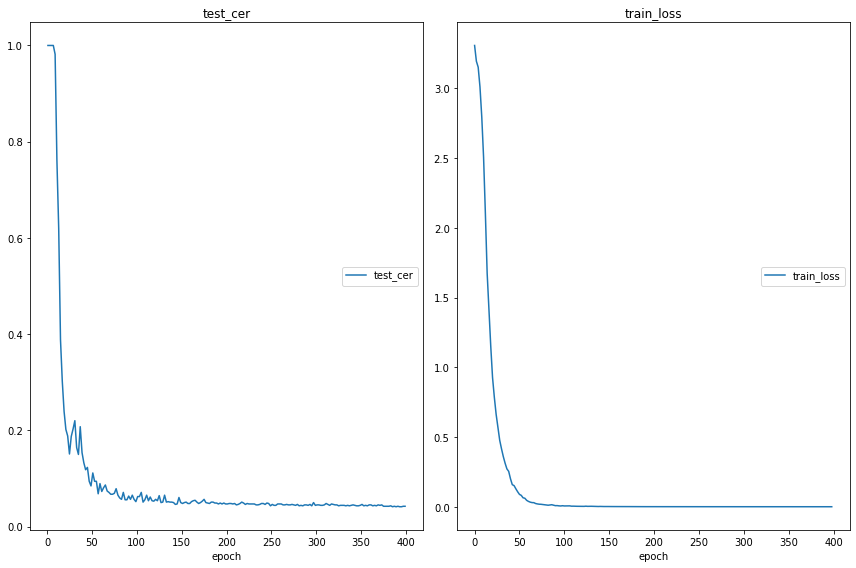

test_cer
	test_cer         	 (min:    0.041, max:    1.000, cur:    0.042)
train_loss
	train_loss       	 (min:    0.000, max:    3.308, cur:    0.000)


In [15]:
import matplotlib.pyplot as plt

epochs = 200

criterion = nn.CTCLoss()
optimizer = optim.Adam(ocr_model.parameters())

plotlosses = PlotLosses()

min_cer = 1.0
for epoch in range(epochs):
    ocr_model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()

        input, labels = batch["images"], batch["labels"]

        input = input.cuda()
        labels = labels.cuda()

        preds = ocr_model(input).permute(1, 0, 2)
        loss = criterion(preds, labels, torch.ones((input.shape[0],), dtype=torch.int32) * NUM_SPLITS, torch.ones((input.shape[0],), dtype=torch.int32) * 5)
        loss.backward()

        optimizer.step()
        running_loss += loss.detach().cpu().item()
    
    mean_loss = running_loss / len(train_dataloader)
    plotlosses.update({
        'train_loss': mean_loss,
    })
    
    ocr_model.eval()
    running_cer = 0.0
    for batch in test_dataloader:
        input, text = batch["images"], batch["text"]

        input = input.cuda()

        preds = ocr_model(input).permute(1, 0, 2)
        pred_text = greedy_decoder(preds)
        if len(pred_text):
            cer = calc_cer(text[0], pred_text[0])
        else:
            cer = len(text)
        running_cer += cer
    
    mean_cer = running_cer / len(test_dataloader)
    if mean_cer < min_cer:
        torch.save(ocr_model.state_dict(), "/content/best_ocr.pth")
        min_cer = mean_cer

    plotlosses.update({
        'test_cer': mean_cer,
    })
    plotlosses.send()
    







##As we can see the lowest CER on test is 0.0041 which is equal to 4.1%.

##Utils and top-9 worst images in terms of CER on test set.

In [43]:
model = ConvExtractor(3, 4).cuda();
ocr_model = OCRModel(model, NUM_SPLITS, 256, 2, dict_len, "cuda")
ocr_model.load_state_dict(torch.load("/content/best_ocr.pth"))

ocr_model.cuda();

def convert2img(tensor):
    mean_std = np.array([0.5, 0.5, 0.5])
    mean_std = np.reshape(mean_std, (1, 1, 3))

    image_pil = tensor.squeeze().cpu().permute(1, 2, 0).numpy() * mean_std + mean_std

    return image_pil

@torch.no_grad()
def find_top_9_worst_cer(model, decoder, test_dataloader):
    model.eval()
    cers = []
    texts = []
    for batch in test_dataloader:
          input, text = batch["images"], batch["text"]

          input = input.cuda()

          preds = ocr_model(input).permute(1, 0, 2)
          pred_text = greedy_decoder(preds)
          if len(pred_text):
              cer = calc_cer(text[0], pred_text[0])
              texts.append(pred_text[0])
          else:
              cer = len(text)
              texts.append("")
          cers.append(cer)
    
    topk = torch.topk(torch.Tensor(cers), k=9)
    indices = topk.indices
    value = topk.values

    images = [test_dataloader.dataset[idx]["images"] for idx in indices]
    images = [convert2img(image) for image in images]

    texts = [texts[idx] for idx in indices]
    
    fig, axis = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(3):
        for j in range(3):
            axis[i][j].imshow(images[i * 3 + j])
            axis[i][j].set_title("Prediction: " + texts[i * 3 + j])

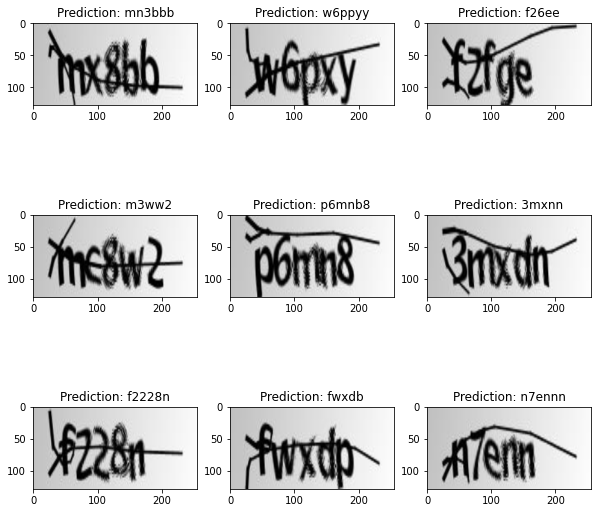

In [44]:
find_top_9_worst_cer(ocr_model, greedy_decoder, test_dataloader)

##Thoughts on why there is such a poor performance on these examples:

Most of the examples has duplicate letters where it shouldn't be the case, most probably it is because of how CTC Loss works, it predicts letter-blank-letter, instead of letter-letter-letter for example. May be increasing or decreasing amount of NUM_SPLITS could help there.    

Also looks like my network confuses 3 and 8 for some reason.

Also it confused x and y in the second example, but I can see why, they are pretty similar and also this random lines on top of captcha can add some ambiguity.   

Some other errors are pure random and I can't explain why model behaved like that.